In [11]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

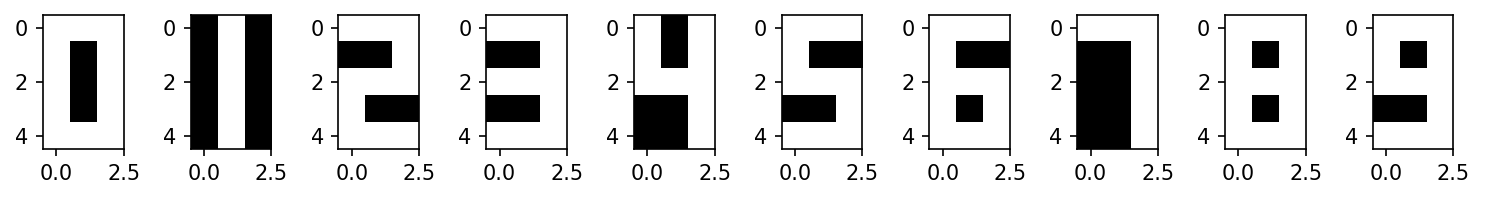

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_figwidth(10)
fig.set_dpi(150)

nums_mtrx =  np.loadtxt(Path('.', 'basic', 'numbers.txt'))

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(5, 3), cmap='gray')

plt.tight_layout()
plt.show()

In [13]:
cells_columns = [f'c{n}' for n in range(15)]
classes = ['zero','one','two','three','four','five','six','seven','eight','nine']

df = pd.DataFrame(columns=cells_columns+['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, nums_mtrx[i]))
    new_row['class'] = classes[i]
    
    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.5, 15)
        
        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]
        
        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

In [14]:
test_frac = 0.7

p = np.arange(10)

test_size = int(p.size*test_frac)
train_size = int(p.size*(1-test_frac))

idx_test = np.ravel([(p[0 : test_size] + i*10) for i in range(10)])
idx_train = np.ravel([(p[test_size : p.size] + i*10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

xTest = np.array(df.iloc[idx_test][features_columns])
yTest = np.array(df.iloc[idx_test][label_columns])

xTrain = np.array(df.iloc[idx_train][features_columns])
yTrain = np.array(df.iloc[idx_train][label_columns])

In [15]:
@njit(fastmath=True)
def F(x: np.ndarray) -> np.ndarray:
    # return x
    return np.maximum(np.zeros(x.shape), x)
    # return np.clip(x,-1, 1)
    # return np.tanh(x)


@njit(fastmath=True)
def dF(x: np.ndarray) -> np.ndarray:
    # return np.ones(x.shape)
    return 1 * (x > 0)
    # return np.array([0 if xi <= -1 or xi >= 1 else 1 for xi in x])
    # return 1-np.square(np.tanh(x))


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1/(1+np.exp(-x))
    return y*(1-y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y/np.sum(y)

In [16]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, w: np.ndarray, Wh: np.ndarray, Bh:np.ndarray, Bx:np.ndarray, b:np.ndarray) -> tuple[np.ndarray]:
    dWh = np.zeros(Wh.shape)
    dBh = np.zeros(Bh.shape)
    dBx = np.zeros(Bx.shape)
    
    dw = np.zeros(w.shape)
    db = np.zeros(b.shape)

    Uh = np.zeros((Wh.shape[0], Wh.shape[2]))
    Xh = np.zeros(Wh.shape[1])
    
    for i in prange(xBatch.shape[0]):
        Uh *= 0
        Xh *= 0

        for j in prange(Wh.shape[0]):
            Uh[j] = xBatch[i] @ Wh[j] + Bh[j]
            Xh += F(Uh[j]) @ Wh[j].T + Bx[j]

        y = softmax(Xh @ w + b)
                
        for j in prange(Wh.shape[0]):
            dLdu = (y-yBatch[i]) @ w.T
            
            dWh[j] += np.outer(xBatch[i], dLdu @ Wh[j] * dF(Uh[j]))
            dBh[j] += dLdu @ Wh[j] * dF(Uh[j])
            dBx[j] += dLdu
        
        dw += np.outer(Xh, y-yBatch[i])
        db += y-yBatch[i]
    
    return (dWh, dw, dBh, dBx, db)

class RBMPerceptron:
    def __init__(self, nL:int, nH:int, nIn:int, nOut:int) -> None:
        self.nL = nL
        self.nH = nH
        self.nIn = nIn
        self.nOut = nOut
                
        self.Wh: np.ndarray = np.random.uniform(-1, 1, (nL, nIn, nH))
        self.w: np.ndarray = np.random.uniform(-1, 1, (nIn, nOut))
        
        self.Bh: np.ndarray = np.zeros((nL, nH))
        self.Bx: np.ndarray = np.zeros((nL, nIn))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x:np.ndarray) -> np.ndarray:
        Yh = np.zeros(self.nIn)
        
        for i in range(self.Wh.shape[0]):
            Yh += F(x @ self.Wh[i] + self.Bh[i]) @ self.Wh[i].T + self.Bx[i]
            
        return softmax(Yh @ self.w + self.b)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_iter) -> None:
        n = xTrain.shape[0]

        for i in range(max_iter):
            idxs = np.random.choice(a=np.arange(n), size=batch_size, replace=False)
            
            dWh, dw, dBh, dBx, db = grads(xTrain[idxs], yTrain[idxs], self.w, self.Wh, self.Bh, self.Bx, self.b)
            
            self.Wh -= lr*dWh
            self.Bh -= lr*dBh
            self.Bx -= lr*dBx
            
            self.w -= lr*dw
            self.b -= lr*db
        
    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        Ypred = np.array([self.predict(xi) for xi in x])
        h = -np.sum(y*np.log(Ypred), axis=1)
        return 1/x.shape[0] * np.sum(h)

In [64]:
nL = 5
nH = 5
nIn = 15
nOut = 10

lr = 1e-2
batch_size = 16
max_iter = 10000

model = RBMPerceptron(nL, nH, nIn, nOut)

print('untrained loss: ', model.loss(xTest, yTest).round(4))

model.train(
    xTrain,
    yTrain,
    lr,
    batch_size,
    max_iter
)

print('trained loss: ', model.loss(xTest, yTest).round(4))

TP_count = 0
for x,y in zip(xTest, yTest):
    yPred = model.predict(x)
    TP_count += 1 if np.argmax(y) == np.argmax(yPred) else 0

accuracy = TP_count / xTest.shape[0]
print('accuracy: ', round(accuracy, 3))

untrained loss:  20.6995
trained loss:  0.0331
accuracy:  0.986


In [67]:
for i, num in enumerate(nums_mtrx):
    yPred = model.predict(num+np.random.uniform(0, 1, 15)).round(2)
    print(i, i == np.argmax(yPred), yPred)

0 False [0.3 0.  0.  0.  0.  0.  0.  0.  0.7 0. ]
1 True [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
2 True [0.   0.   0.99 0.   0.   0.   0.01 0.   0.   0.  ]
3 True [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
4 True [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
5 True [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
6 True [0.   0.   0.   0.   0.   0.   0.93 0.   0.07 0.  ]
7 False [0.98 0.   0.   0.02 0.   0.   0.   0.   0.   0.  ]
8 False [0.02 0.   0.   0.   0.   0.   0.85 0.   0.13 0.  ]
9 True [0.   0.05 0.   0.03 0.   0.   0.   0.   0.   0.93]


In [66]:
for x,y in zip(xTest, yTest):
    print(y, model.predict(x).round(2))

[1 0 0 0 0 0 0 0 0 0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1 0 0 0 0 0 0 0 0 0] [0.71 0.   0.   0.   0.   0.   0.   0.   0.29 0.  ]
[1 0 0 0 0 0 0 0 0 0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1 0 0 0 0 0 0 0 0 0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1 0 0 0 0 0 0 0 0 0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1 0 0 0 0 0 0 0 0 0] [0.95 0.   0.   0.   0.   0.   0.   0.   0.05 0.  ]
[1 0 0 0 0 0 0 0 0 0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0.   0.92 0.08 0.   0.   0.   0.   0.   0.   0.  ]
[0 0 1 0 0 0 0 0 0 0] [0.   0.   0.99 0.   0.   0.   0.   0.   0.01 0.  ]
[0 0 1 0 0 0 0 0 0 0] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0 0 1 0 0 0 0 0 0 0] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0

0 | 0.0
1 | 0.0
2 | 0.52
3 | 0.42
4 | 0.01
5 | 0.0
6 | 0.0
7 | 0.0
8 | 0.06
9 | 0.0


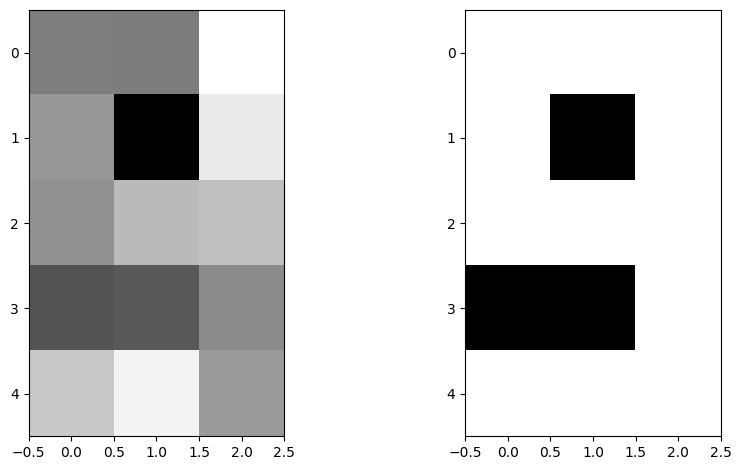

In [72]:
i = random.randint(0,9)

x = nums_mtrx[i]
x_noised = x + np.random.uniform(0, 1, 15)

yPred = model.predict(x_noised)
for i in range(10):
    print(i, '|', round(yPred[i], 2))

fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_dpi(100)
fig.set_figwidth(10)

axes[0].imshow(x_noised.reshape((5,3)), cmap='gray')
axes[1].imshow(x.reshape((5,3)), cmap='gray')

plt.tight_layout()
plt.show()